<a href="https://colab.research.google.com/github/twloehfelm/SAR2020/blob/master/02%20-%20DICOM_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table width="100%">
    <tr>
        <td valign="top"><img src="https://cdn.ymaws.com/www.abdominalradiology.org/graphics/logo.jpg"/></td>
        <td valign="middle" align="right"><h1>SAR 2020<br/>AI Masters Class</td>
    </tr>
    <tr>
      <td align="center" colspan=2><h1>DICOM Basics</h1></td>
    </tr>
</table>

Radiologists live and breathe DICOM, the standard file format for all diagnostic imaging studies.

DICOM files contain the actual pixel values for the image, of course, but also a bunch of *metadata*, or data about data.

DICOM metadata encodes the context of the image - which patient it refers to, when and where it was obtained, how it relates to other images (i.e. as part of the same series or study), and some technical parameters that might be necessary to properly reconstruct the full image set.

```pydicom``` is a popular Python library for dealing with DICOM data. If we install it on our Colab VM we can then import it and use its functions to manipulate DICOM.



In [0]:
%matplotlib inline

# Install pydicom on the linux VM
!pip3 install pydicom

import pydicom
from pydicom import dcmread
from pydicom.errors import InvalidDicomError
import matplotlib.pyplot as plt
import os, sys
from skimage import exposure, io, util
from skimage.transform import resize

In [0]:
# Download a few example dicom radiographs and save them to /content/images/abdxr_dicom
!wget -q --no-check-certificate 'https://www.dropbox.com/s/9uryqy3fplyy05n/dicoms.zip' -O ./dicoms.zip
!mkdir -p images
!rm -rf ./images/dicoms
!mkdir ./images/dicoms
!cd images; unzip -q "../dicoms.zip" -d dicoms
# get rid of MAC garbage stuff
!rm -rf ./images/__MACOSX
!ls images

dicoms


In [0]:
size = 256, 256
dicomdir = "/content/images/dicoms"

In [0]:
# from fastai2 medical imaging
def windowed(px, w, l):
    """Windows a pixel_array of Houndfield units
    args:
      px = pixel array in Houndfield units
      w = window width (HU range)
      l = window level (center point)
    returns:
      pixel_array convered to the given window/level
    """
    if type(w) == pydicom.multival.MultiValue:
      w = w[0]
    if type(l) == pydicom.multival.MultiValue:
      l = l[0]
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min) 


Filename..................: dcm05
Storage type..............: 1.2.840.10008.5.1.4.1.1.2

Patient name..............: PATIENT, 876930919
Patient ID................: HrzHybwOmJ
Modality..................: CT
Rescale Intercept.........: 0
Rescale Slope.............: 1.000000
Image size ...............: 1024 x 1024, 2097152 bytes
Photometric Interpretation: MONOCHROME2


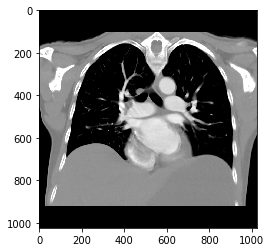


Filename..................: dcm03
Storage type..............: 1.2.840.10008.5.1.4.1.1.2

Patient name..............: PATIENT, 1578595953
Patient ID................: Si9JYiZQts
Modality..................: CT
Rescale Intercept.........: -1024
Rescale Slope.............: 1.000000
Image size ...............: 522 x 512, 534528 bytes
Photometric Interpretation: MONOCHROME2


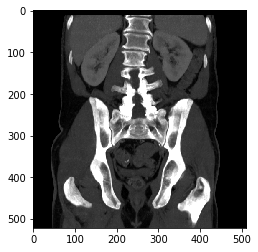


Filename..................: dcm04
Storage type..............: 1.2.840.10008.5.1.4.1.1.2

Patient name..............: PATIENT, 1702756747
Patient ID................: 3EtJuXFaXu
Modality..................: CT
Rescale Intercept.........: 0
Rescale Slope.............: 1.000000
Image size ...............: 512 x 512, 524288 bytes
Photometric Interpretation: MONOCHROME2


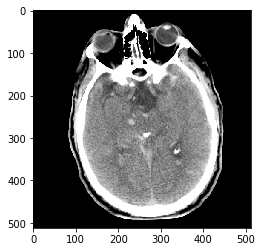


Filename..................: dcm02
Storage type..............: 1.2.840.10008.5.1.4.1.1.2

Patient name..............: PATIENT, 228623729
Patient ID................: CsypH4iX2I
Modality..................: CT
Rescale Intercept.........: 0
Rescale Slope.............: 1.000000
Image size ...............: 1024 x 1024, 2097152 bytes
Photometric Interpretation: MONOCHROME2


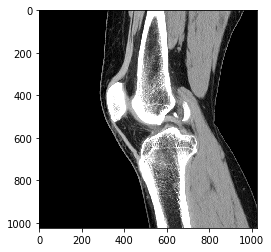


Filename..................: dcm01
Storage type..............: 1.2.840.10008.5.1.4.1.1.2

Patient name..............: PATIENT, 1578595953
Patient ID................: Si9JYiZQts
Modality..................: CT
Rescale Intercept.........: -1024
Rescale Slope.............: 1.000000
Image size ...............: 512 x 512, 524288 bytes
Photometric Interpretation: MONOCHROME2


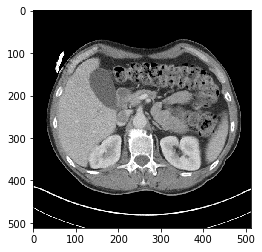

In [0]:
# Read each of the files in dicomdir, print some metadata, and show the image
for root, dirs, files in os.walk(dicomdir):
  for f in files:
    try:
      ds = dcmread(os.path.join(dicomdir, f))
    except (PermissionError, InvalidDicomError, FileNotFoundError):
      continue
    
    im = ds.pixel_array
    im = im*ds.RescaleSlope + ds.RescaleIntercept
    im = windowed(im, ds.WindowWidth, ds.WindowCenter)
    if(ds.PhotometricInterpretation == 'MONOCHROME2'):
        cmap=plt.cm.bone
    elif(ds.PhotometricInterpretation == 'MONOCHROME1'):
        cmap=plt.cm.bone_r
    else:
        print("Unknown Photometric Interpretation")
        cmap=plt.cm.bone
        continue
    
    print()
    print("Filename..................:", f)
    print("Storage type..............:", ds.SOPClassUID)
    print()

    pat_name = ds.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient name..............:", display_name)
    print("Patient ID................:", ds.PatientID)
    print("Modality..................:", ds.Modality)
    print("Rescale Intercept.........:", ds.RescaleIntercept)
    print("Rescale Slope.............:", ds.RescaleSlope)
    
    if 'PixelData' in ds:
      rows = int(ds.Rows)
      cols = int(ds.Columns)
      print("Image size ...............: {rows:d} x {cols:d}, {size:d} bytes".format(
          rows=rows, cols=cols, size=len(ds.PixelData)))
      print("Photometric Interpretation:", ds.PhotometricInterpretation)
    
    plt.imshow(im, cmap="gray")  
    plt.show()

In [0]:
# Look at the entire DICOM metadata header
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7238010.5.1.4.0.5085.1581750789.3
(0008, 0020) Study Date                          DA: '20110807'
(0008, 0021) Series Date                         DA: '20110807'
(0008, 0022) Acquisition Date                    DA: '20110807'
(0008, 0023) Content Date                        DA: '20110807'
(0008, 002a) Acquisition DateTime                DT: '20110807084305.071'
(0008, 0030) Study Time                          TM: '083851.553000'
(0008, 0031) Series Time                         TM: '084312.272000'
(0008, 0032) Acquisition Time                    TM: '084305.071000'
(0008, 0033) Content Time                        TM: '084305.071000'
(0008, 0050) Accession Number                    SH: 'WkJFmF

If you follow along in the code block above, you'll see that we read the pixel data from the DICOM file with 

```
im = ds.pixel_array
```

What IS a pixel array? And while we're at it, how is it that we can do math with images??

A pixel array is nothing more than numbers organized in rows and columns.

In fact, we can create an array, save it to a file, and open it directly in Excel! 

In [0]:
import numpy as np
# Create a simple 5x5 array of 0s and 1s
ar = np.asarray(
    [
      [1, 0, 0, 0, 1],
      [0, 1, 0, 1, 0],
      [0, 0, 1, 0, 0],
      [0, 1, 0, 1, 0],
      [1, 0, 0, 0, 1],
    ]
  ) 

np.savetxt('array.csv', ar, delimiter=",")

# See what happens when we resize it
size = (64, 64)
ar = resize(ar, size, mode='constant', cval=0, preserve_range=True)
np.savetxt('array_resized.csv', ar, delimiter=",")

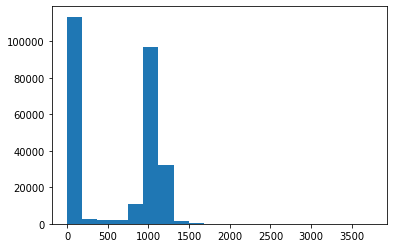

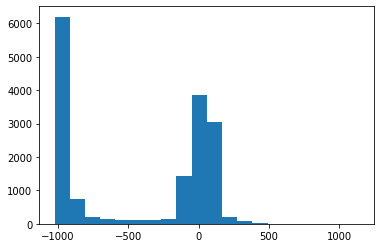

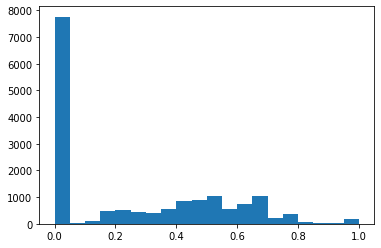

In [0]:
# We can do the same thing with the DICOM pixel array!
im = ds.pixel_array
#plt.hist(im.flatten(), bins=20)
#plt.show()
im = im*ds.RescaleSlope + ds.RescaleIntercept
im = resize(im, [128, 128], preserve_range=True)
#plt.hist(im.flatten(), bins=20)
#plt.show()
np.savetxt("dicom.csv", im, delimiter=",")

im = windowed(im, ds.WindowWidth, ds.WindowCenter)
#plt.hist(im.flatten(), bins=20)
#plt.show()
np.savetxt("dicom_windowed.csv", im, delimiter=",")

Thinking of an image as a spreadsheet containing organized rows and columns of numbers helps to de-mystify the idea of performing math operations on images - neural network operations on image data are no different than adding, averaging, or finding the maximum value in a range of Excel cells, and then creating new arrays from the results of those operations, peforming similar operations again, ad infinitum :)

You can actually implement a simple facial recognition algorithm (and any other type of neural network if you try hard enough) [completely in Excel](https://towardsdatascience.com/cutting-edge-face-recognition-is-complicated-these-spreadsheets-make-it-easier-e7864dbf0e1a)! 